In [1]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import nabla, grad
from pina.model import Network
from pina import Condition, Span, PINN, Plotter

In [2]:
class Wave(TimeDependentProblem, SpatialProblem):
	output_variables = ['u']
	spatial_domain = Span({'x': [0, 1], 'y': [0, 1]})
	temporal_domain = Span({'t': [0, 1]})

	def wave_equation(input_, output_):
		u_t = grad(output_, input_, components=['u'], d=['t'])
		u_tt = grad(u_t, input_, components=['dudt'], d=['t'])
		nabla_u = nabla(output_, input_, components=['u'], d=['x', 'y'])
		return nabla_u - u_tt

	def nil_dirichlet(input_, output_):
		value = 0.0
		return output_.extract(['u']) - value

	def initial_condition(input_, output_):
		u_expected = (torch.sin(torch.pi * input_.extract(['x'])) *
		              torch.sin(torch.pi * input_.extract(['y'])))
		return output_.extract(['u']) - u_expected

	conditions = {
		'gamma1': Condition(location=Span({'x': [0, 1], 'y': 1, 't': [0, 1]}), function=nil_dirichlet),
		'gamma2': Condition(location=Span({'x': [0, 1], 'y': 0, 't': [0, 1]}), function=nil_dirichlet),
		'gamma3': Condition(location=Span({'x': 1, 'y': [0, 1], 't': [0, 1]}), function=nil_dirichlet),
		'gamma4': Condition(location=Span({'x': 0, 'y': [0, 1], 't': [0, 1]}), function=nil_dirichlet),
		't0': Condition(location=Span({'x': [0, 1], 'y': [0, 1], 't': 0}), function=initial_condition),
		'D': Condition(location=Span({'x': [0, 1], 'y': [0, 1], 't': [0, 1]}), function=wave_equation),
	}

	def wave_sol(self, pts):
		return (torch.sin(torch.pi * pts.extract(['x'])) *
		        torch.sin(torch.pi * pts.extract(['y'])) *
		        torch.cos(torch.sqrt(torch.tensor(2.)) * torch.pi * pts.extract(['t'])))

	truth_solution = wave_sol


In [3]:
class TorchNet(torch.nn.Module):

	def __init__(self):
		super().__init__()

		self.residual = torch.nn.Sequential(torch.nn.Linear(3, 24),
		                                    torch.nn.Tanh(),
		                                    torch.nn.Linear(24, 3))

		self.mlp = torch.nn.Sequential(torch.nn.Linear(3, 64),
		                               torch.nn.Tanh(),
		                               torch.nn.Linear(64, 1))

	def forward(self, x):
		residual_x = self.residual(x)
		return self.mlp(x + residual_x)

In [44]:

problem = Wave()

model = Network(model=TorchNet(),
				input_variables=problem.input_variables,
				output_variables=problem.output_variables,
				extra_features=None)
pinn = PINN(problem, model, lr=0.001)
# print(pinn.problem.conditions['gamma1'])
pinn.span_pts(1000, 'random', locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'])
# pinn.input_pts['gamma3'].shape
pinn.span_pts(100, 'random', locations=['D', 't0', 'gamma1'])

for key in pinn.problem.conditions:
	print(key)
	print(key["gamma1"])
	print(pinn.input_pts[key].shape)

gamma1


TypeError: string indices must be integers

In [39]:
def generate_samples_and_train(model, problem):
	# generate pinn object
	pinn = PINN(problem, model, lr=0.001)

	pinn.span_pts(1000, 'random', locations=['D', 't0', 'gamma1', 'gamma2', 'gamma3', 'gamma4'])
	pinn.train(stop=3000, frequency_print=150)
	return pinn

In [40]:
problem = Wave()

model = Network(model=TorchNet(),
                input_variables=problem.input_variables,
                output_variables=problem.output_variables,
                extra_features=None)

pinn = generate_samples_and_train(model, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00000] 5.585984e-01 2.840892e-02 1.122404e-01 1.773801e-02 6.187706e-02 3.381503e-01 1.837334e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00001] 2.771468e-01 3.784976e-03 2.918075e-02 8.517515e-03 1.474879e-02 2.201676e-01 7.471102e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00150] 1.758220e-01 1.004363e-02 1.306213e-02 1.039253e-02 1.151867e-02 1.305005e-01 3.045647e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00300] 1.746776e-01 1.007552e-02 1.307786e-02 1.075001e-02 1.116596e-02 1.291543e-01 4.539521e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00450] 1.732184e-01 1.005225e-02 1.3057

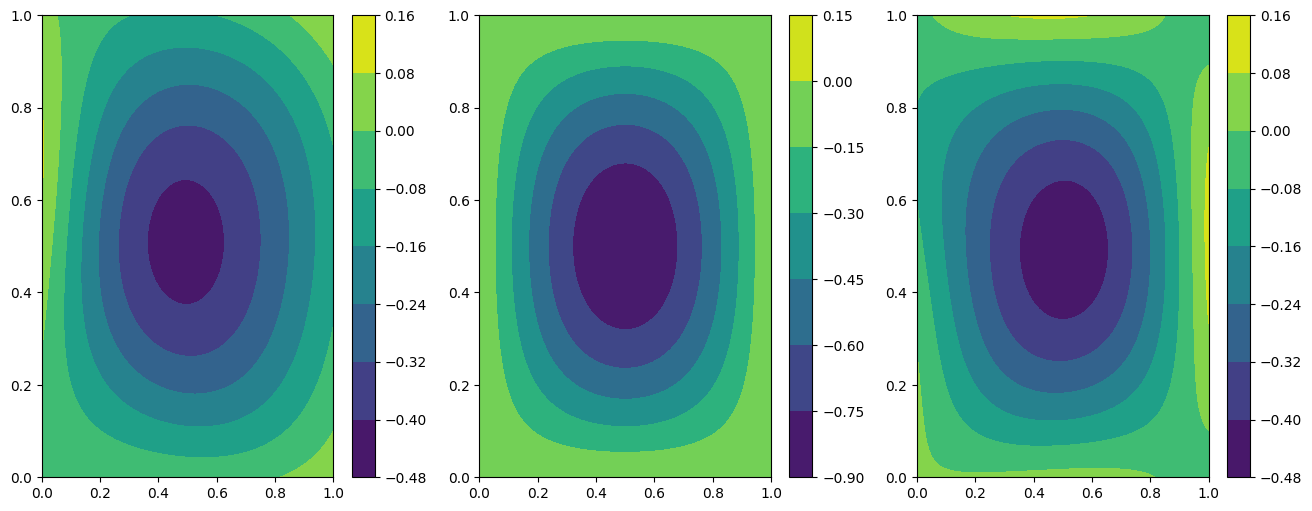

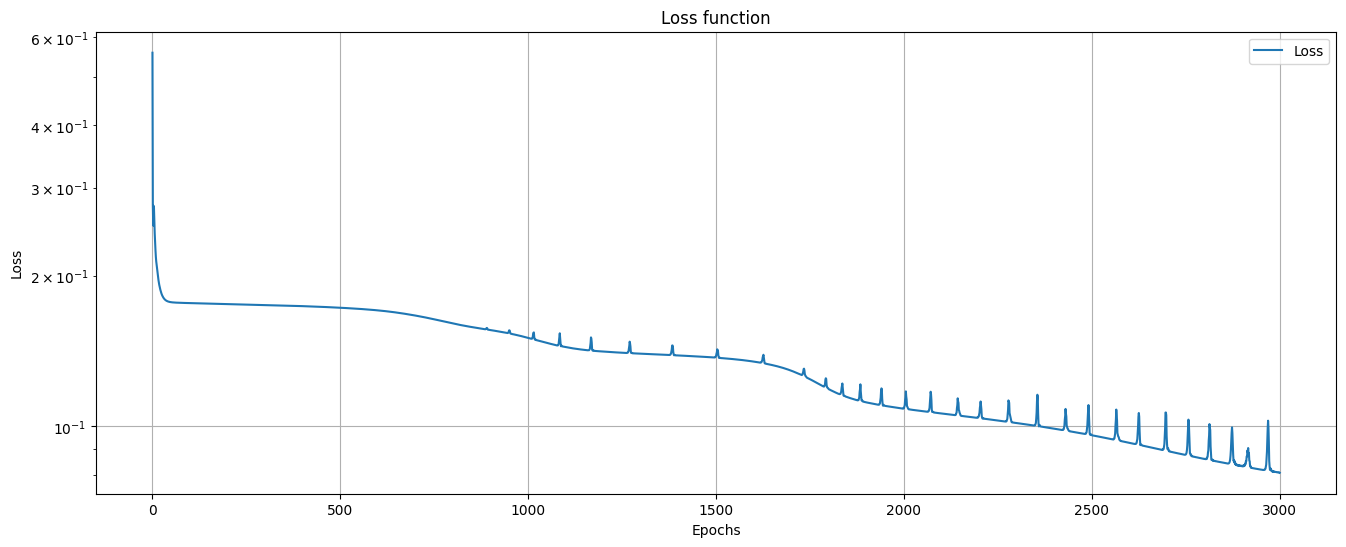

In [41]:
plotter = Plotter()

# plotting at fixed time t = 0.6
plotter.plot(pinn, fixed_variables={'t': 0.6})

# We can also plot the pinn loss during the training to see the decrease.

# In[9]:


import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plotter.plot_loss(pinn, label='Loss')

plt.grid()
plt.legend()
plt.show()